In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit,njit

In [2]:
output_path = '/home/bruce1996/data/pr/0707/'

metaphlan_output = "/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_species_relative_abundance.txt"
metadata = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_sample_diagnosis.csv',sep = '\t',index_col=0)
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)
selected_df = pd.read_csv('/home/bruce1996/nvme2/mci_for_adlasso/MCI/selected_feature.txt',sep = '\t',header=None)
selected_s = selected_df.iloc[:,0].values
candidate_df = meta_df.loc[selected_s,:]

In [3]:
pv_lambda = lambda x : 100*(sum(x>0) / len(x))
pv = list(map(pv_lambda,candidate_df.to_numpy()))

In [4]:
import re
b_idx = [bool(re.search('Bifidobacterium',x)) for x in meta_df.index]
l_idx = [bool(re.search('Lactobacillus',x)) for x in meta_df.index]
b_df = meta_df.loc[b_idx,:]
l_df = meta_df.loc[l_idx,:]

In [8]:
l_subtype_df = pd.read_csv('~/data/lacto-subtype.csv')

In [10]:
l_subtype_dict = dict()
for i in range(l_subtype_df.shape[0]) :
    s = l_subtype_df['species'][i]
    s = 's__' +s.replace(' ','_')
    type = l_subtype_df['phylogroup'][i]
    type = type + '_' + 'subtype'
    l_subtype_dict[s] = type    

l_subtype_dict['s__Lactobacillus_casei_paracasei'] = 'Lacticaseibacillus_subtype'

In [14]:
l_subtype_dict['s__Lactobacillus_casei_paracasei'] = 'Lacticaseibacillus_subtype'

In [6]:
def node_prevalence(df,label,title,fig_output,xlabel,ylabel,measure='pv') :
    if measure == 'pv' :
        pv_lambda = lambda x : 100 * ( sum(x>0) / len(x))
        x = list(map(pv_lambda,df.loc[:,label].to_numpy()))
        y = list(map(pv_lambda,df.loc[:,label==False].to_numpy()))
    elif measure == 'mab' :
        x = df.loc[:,label].mean(axis=1)
        y = df.loc[:,label == False].mean(axis=1)
    plt.scatter(x = x,y=y,c=y,cmap='rainbow')
    mi= min(min(x),min(y))
    ma = max(max(x),max(y))
    plt.plot([0,ma],[0,ma], 'r-')

    if measure == 'pv' :
        plt.xlim([mi-1,ma+1])
        plt.ylim([mi-1,ma+1])
    elif measure == 'mab' :
        plt.xlim([mi-0.005,ma+0.005])
        plt.ylim([mi-0.005,ma+0.005])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(fig_output)
    plt.show()

In [24]:
from scipy.stats import mannwhitneyu

def wilconox_for_species(df,y) :
    n = df.shape[0]
    n_idx = y == False
    pv = np.zeros(n)
    for i in range(n) :
        y1 = df.iloc[i,:][y]
        y2 = df.iloc[i,:][n_idx]
        _,pv[i] = mannwhitneyu(y1,y2)
    return pv

### Subtyping

In [20]:
l_subtype_dict = dict()
for i in range(l_subtype_df.shape[0]) :
    s = l_subtype_df['species'][i]
    s = 's__' +s.replace(' ','_')
    type = l_subtype_df['phylogroup'][i]
    type = type + '_' + 'subtype'
    l_subtype_dict[s] = type    

l_subtype_dict['s__Lactobacillus_casei_paracasei'] = 'Lacticaseibacillus_subtype'

idx = list()
for i in range(l_df.shape[0]) :
    if l_df.index[i] in l_subtype_dict.keys() :
        s = l_df.index[i]
        subtype = l_subtype_dict[s]
    else :
        subtype = 'Lactobacillus_others'
    idx.append(subtype)

l_df.index = idx

### NMF

In [16]:
from sklearn.decomposition import NMF

In [86]:
lacto_df = pd.read_csv('~/ssd/probiotics_fingerprint/curatedmetagenomic/curated_lacto_subtype_by_ref_rel_matrix.txt',sep = '\t',index_col=0)
bifido_df = pd.read_csv('~/ssd/probiotics_fingerprint/curatedmetagenomic/curated_bifido_subtype_rel_matrix.txt',sep = '\t',index_col=0)

lacto_matrix = pd.read_csv('~/ssd/probiotics_fingerprint/subtype/lacto_subtype_by_ref_rel_matrix.txt',sep = '\t',index_col=0)
bifido_matrix = pd.read_csv('~/ssd/probiotics_fingerprint/subtype/bifido_subtype_rel_matrix.txt',sep='\t',index_col=0)
#fill missing subtype

missing = list(set(lacto_df.index) - set(lacto_matrix.index))
missing_matrix = pd.DataFrame(np.zeros([len(missing),100]),index = missing,columns=lacto_matrix.columns)
lacto_matrix = pd.concat([lacto_matrix,missing_matrix],axis = 0)

missing = ['B.asteroides', 'B.boum', 'B.pullorum']
missing_matrix = pd.DataFrame(np.zeros([3,100]),index = missing,columns=bifido_matrix.columns)
bifido_matrix = pd.concat([bifido_matrix,missing_matrix],axis = 0)
del missing

"\nmissing = ['L.brevis']\nmissing_matrix = pd.DataFrame(np.zeros([1,100]),index = missing,columns=lacto_matrix.columns)\nlacto_matrix = pd.concat([lacto_matrix,missing_matrix],axis = 0)\n\nmissing = ['B.asteroides', 'B.boum', 'B.pullorum']\nmissing_matrix = pd.DataFrame(np.zeros([3,100]),index = missing,columns=bifido_matrix.columns)\nbifido_matrix = pd.concat([bifido_matrix,missing_matrix],axis = 0)\n"

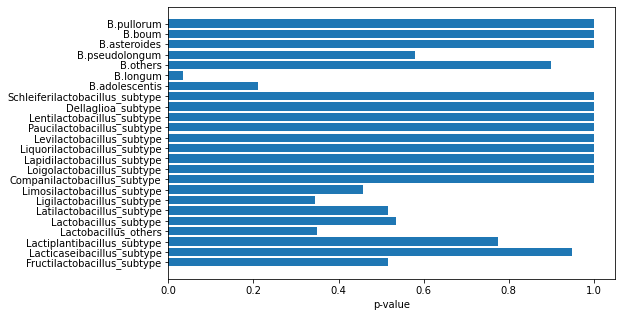

In [92]:
y = np.where(metadata['Diagnosis'] == 'MCI',True,False)
df = pd.concat([lacto_matrix,bifido_matrix],axis=0)
pv = wilconox_for_species(df,y)
plt.figure(figsize=(8,5))
plt.barh(df.index,pv)
plt.xlabel('p-value')
plt.savefig(output_path + 'subtype-wilconox-test.png')

In [17]:
@jit()
def finger_print_proportion(x,w,h):
    n_finger_print = w.shape[1]
    n_sample = w.shape[0]
    proportion_matrix = np.zeros([n_sample,n_finger_print+1])

    for i in range(n_sample) :
        total = sum(x[i,:])
        accum = 0
        if total == 0 :
            pass
        else :
            for j in range(n_finger_print) :
                ab = sum(np.dot(w[i,j],h[j,:]))
                proportion_matrix[i,j] = ab / total
                accum += (ab / total)

        proportion_matrix[i,-1] = 1 - accum

    return proportion_matrix

In [14]:
def fit_signature(denovo_df,fit_df,k,prefix) :
    X = denovo_df.T.to_numpy()
    x = fit_df.T.to_numpy()
    nmf_model = NMF(n_components=k, init='random', random_state=0)
    nmf_model.fit(X)
    w = nmf_model.transform(x)
    H = nmf_model.components_

    finger_print_matrix = finger_print_proportion(x,w,H)
    index_b = [prefix + ' signature ' + str(x) for x in range(1,k+1)]
    index_b.append(prefix + ' residual')

    finger_print_df = pd.DataFrame(finger_print_matrix.T,index=index_b,columns=bifido_matrix.columns)

    return finger_print_df

In [18]:
from matplotlib import cm

def plot_signature(H,index,prefix,subplot_x,subplot_y,fig_output,figsize = (12,6)) :
    n_sig ,n_feature = H.shape
    cmap = cm.Set2(np.linspace(0, 1, 7))
    fig,axes = plt.subplots(subplot_x,subplot_y,figsize=figsize)
    for idx,axs in enumerate(axes.ravel()) :
        x = H[idx,:]
        axs.bar(np.arange(n_feature),x,color = cmap)
        axs.set_xticks(np.arange(n_feature))
        axs.set_xticklabels(index,rotation=90)
        axs.title.set_text(prefix + ' ' + str(idx+1))
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig(fig_output,dpi=300,bbox_inches='tight')
    plt.show()


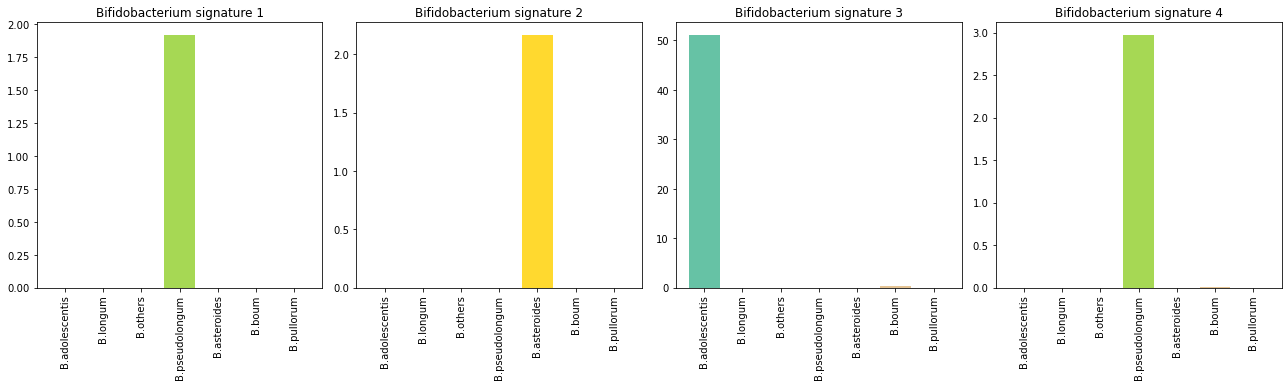

In [146]:
Xb = bifido_df.T.to_numpy()
xb = bifido_matrix.T.to_numpy()
k = 4
nmf_b = NMF(n_components=k, init='random', random_state=0)
nmf_b.fit(Xb)
H = nmf_b.components_

plot_signature(H,list(bifido_matrix.index),'Bifidobacterium signature',1,4,output_path + 'global_bifido_sig.png',figsize=(18,6))

In [19]:
df_l = fit_signature(lacto_matrix,lacto_matrix,5,prefix="Lactobacillus")
df_b = fit_signature(lacto_matrix,bifido_matrix,4,prefix='Bifidobacterium')

/tmp/ipykernel_3483869/589611367.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "finger_print_proportion" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 4 candidate implementations:
  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
    With argument(s): '(list(int64)<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic stub>) found for signature:
    
    >>> stub(list(int64)<iv=None>)
    
   There are 2 candidate implementations:
     - Of which 2 did not match due to:
     Intrinsic of function 'stub': File: numba/core/overload_glue.py: Line 35.
       With argum

In [20]:
df_l.to_csv('/home/bruce1996/ssd/probiotics_fingerprint/global_lacto_sig_matrix.txt',sep='\t')
df_b.to_csv('/home/bruce1996/ssd/probiotics_fingerprint/global_bifido_sig_matrix.txt',sep='\t')

In [21]:
df = pd.concat([df_b,df_l],axis=0)
df = df.clip(lower=0)

In [19]:
df.to_csv('/home/bruce1996/ssd/probiotics_fingerprint/sig_matrix.txt',sep='\t')

In [22]:
df

,TPMIC01002,TPMIC01004,TPMIC01005,TPMIC01006,TPMIC01007,TPMIC01008,TPMIC01009,TPMIC01010,TPMIC01011,TPMIC01015,...,TPMIC03071,TPMIC03072,TPMIC03075,TPMIC03083,TPMIC03022,TPMIC03042,TPMIC03070,TPMIC03084,TPMIC03089,TPMIC03091
Bifidobacterium signature 1,0.995812,0.267223,0.597708,0.000008,0.870093,1.029257,0.063346,0.000000,0.740751,0.563223,...,1.019228,0.518342,0.725737,0.915792,0.758318,0.542923,1.028987,0.497873,0.841088,0.359720
Bifidobacterium signature 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bifidobacterium signature 3,0.032518,0.740924,0.331932,1.000737,0.154753,0.000000,0.897585,0.000000,0.280513,0.453123,...,0.009750,0.496761,0.295111,0.110321,0.263433,0.472861,0.000261,0.516663,0.182956,0.650989
Bifidobacterium signature 4,0.000000,0.000000,0.004601,0.000000,0.000000,0.000000,0.001807,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bifidobacterium residual,0.000000,0.000000,0.065760,0.000000,0.000000,0.000000,0.037262,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Lactobacillus signature 1,0.079348,0.025836,0.000000,0.000000,0.000000,1.027603,0.000000,1.027603,0.000000,0.000000,...,0.000000,0.000000,1.027603,0.000000,0.000000,0.637334,0.244695,0.000000,1.027603,0.000000
Lactobacillus signature 2,0.006742,0.000042,0.000000,1.007460,0.000000,0.000000,0.000000,0.000000,0.000000,0.974373,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.199601,0.764367,0.000000,0.000000,0.000000
Lactobacillus signature 3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032877,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.174370,0.000000,0.000000,0.000000,0.000000
Lactobacillus signature 4,0.000149,0.009970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Lactobacillus signature 5,0.000000,0.000000,0.000000,0.000732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001696,0.001389,0.000000,0.000000,0.000000


In [11]:
consensus_df = pd.read_csv('/home/bruce1996/ssd/probiotics_fingerprint/consensus_clustering.txt',sep='\t',index_col=0)

In [23]:
idx = metadata.sort_values(by='Diagnosis').index
metadata = metadata.sort_values(by='Diagnosis')
df = df.loc[:,idx]

In [25]:
consensus_df

,cluster
TPMIC01002,1
TPMIC01004,1
TPMIC01005,1
TPMIC01006,2
TPMIC01007,1
...,...
TPMIC03042,3
TPMIC03070,2
TPMIC03084,1
TPMIC03089,3


In [28]:
idx = consensus_df['cluster'] == 1
df_1 = df.loc[:,idx]

In [44]:
output_path

'/home/bruce1996/data/pr/0707/'

'\nfor label in set(diagnosis):\n    g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)\nl2 = g.ax_row_dendrogram.legend(title=\'Diagnosis\', loc="center", ncol=2, bbox_to_anchor=(0.47, 0.9), bbox_transform=gcf().transFigure)\n'

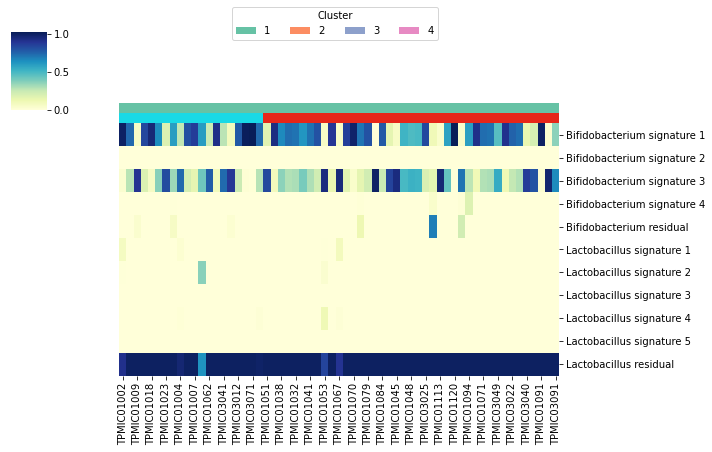

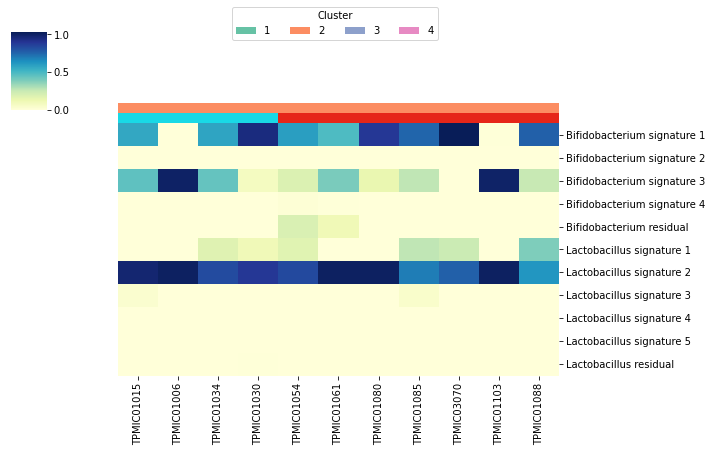

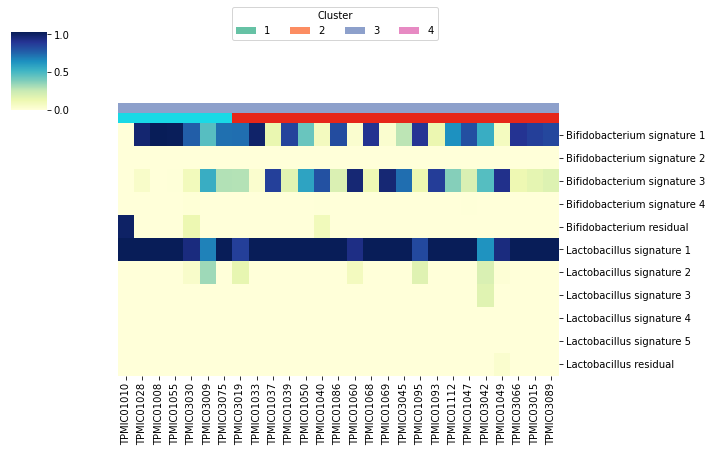

In [46]:
from matplotlib import cm
from matplotlib.pyplot import gcf


'''
all_net_names  = consensus_df['cluster'].values
net_ind = sorted(np.unique(all_net_names, return_index=True)[1])
net_names = [all_net_names[index] for index in sorted(net_ind)]
#network_pal = sns.cubehelix_palette(10, light=.9, dark=.1, reverse=False, start=1, rot=-2)
colormap = [cm.Set2(x) for x in range(7)]
network_pal = colormap
network_lut = dict(zip(np.unique(all_net_names), network_pal))
network_colors = pd.Series(all_net_names).map(network_lut)
'''
cluster = consensus_df['cluster'].values
cluster_lut = dict(zip( set(cluster),  [cm.Set2(x) for x in range(10)] ))
col_colors = pd.Series(cluster).map(cluster_lut)

diagnosis = metadata['Diagnosis'].values
lut = dict(zip( set(diagnosis), sns.hls_palette(len(set(diagnosis)),l=0.5, s=0.8)   ))
row_colors = pd.Series(diagnosis).map(lut)

for i in range(3) :
    idx = consensus_df['cluster'] == i+1
    plot_df = df.loc[:,idx]

    g = sns.clustermap(plot_df, cmap="YlGnBu",
                    row_cluster=False, 
                    col_cluster=False,
                    col_colors=[col_colors[idx.values],row_colors[idx.values]],
                    linewidths=0, figsize=(10, 6))

    for label in set(cluster):
        g.ax_col_dendrogram.bar(0, 0, color=cluster_lut[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cluster', loc="center", ncol=5, bbox_to_anchor=(0.47, 1.0), bbox_transform=gcf().transFigure)
    plt.savefig(output_path + 'signature_consensus_clustering_heatmap_'+str(i)+'.png',dpi = 300)

'''
for label in set(diagnosis):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(title='Diagnosis', loc="center", ncol=2, bbox_to_anchor=(0.47, 0.9), bbox_transform=gcf().transFigure)
'''
#plt.savefig(output_path + 'signature_consensus_clustering_heatmap.png',dpi = 300)